# Data Preparation

In [326]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white' # Since I use a dark IDE

# To allow multiple outputs per cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

## Reading in Data

In [327]:
unwanted_cols = ['Unnamed: 0', 'Subject' , 'TympType']
unwanted_cols_gen = ['Unnamed: 0', 'TympType']

wba_df = pd.read_csv("wba_data_CLEAN.csv")
wba_df = wba_df.drop(columns=unwanted_cols)

wba_gen = pd.read_csv("wba_gen.csv")
wba_gen = wba_gen.drop(columns=unwanted_cols_gen)

wba_gen_balanced = pd.read_csv("wba_gen_balanced.csv")
wba_gen_balanced = wba_gen_balanced.drop(columns=unwanted_cols_gen)

Testing purposes: WBA df only fails

In [328]:
# wba_gen = wba_gen[wba_gen['OverallPoF'] == 1]
wba_df_fails = wba_df[wba_df['OverallPoF'] == 1]

In [329]:
vars = [c for c in wba_df.columns if c[:2] != "f("]

# wba_df[vars].describe()
# wba_gen[vars].describe()
# wba_gen_balanced[vars].describe()

In [330]:
# wba_df[vars].value_counts()
# wba_gen[vars].value_counts()
# wba_gen_balanced[vars].value_counts()

### Feature Selection

From `feature_selection.ipynb`

In [331]:
# # Add selected features here
# features = wba_df.columns 

# wba_df = wba_df

Limiting normative data to same columns as generated

In [332]:
wba_df = wba_df[wba_gen.columns]
wba_gen_balanced = wba_gen_balanced[wba_gen.columns]

# Machine Learning

In [333]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## Train and Test Sets

We will use the generated data as training and normative data as testing

In [334]:
x_vars = [c for c in wba_df.columns if c != "OverallPoF"]

In [335]:
y_train_gen = wba_gen['OverallPoF'].copy()
y_train_bal = wba_gen_balanced['OverallPoF'].copy()
y_train = wba_df['OverallPoF'].copy()
y_test = wba_df['OverallPoF'].copy()
y_test_fails = y_test[wba_df['OverallPoF'] == 1].copy()

X_train = wba_df[x_vars].copy()
X_train_gen = wba_gen[x_vars].copy()
X_train_bal = wba_gen_balanced[x_vars].copy()
X_test = wba_df[x_vars].copy()
X_test_fails = X_test[wba_df['OverallPoF'] == 1].copy()

### Scaling

In [336]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
X_train_gen_scaled = std_scaler.fit_transform(X_train_gen)
X_train_bal_scaled = std_scaler.fit_transform(X_train_bal)
X_test_scaled = std_scaler.transform(X_test)
X_test_fails_scaled = std_scaler.transform(X_test_fails)

## Support Vector Machine

In [337]:
from sklearn import svm

# For convenient performance metrics
from sklearn.metrics import classification_report

In [338]:
svm_classifier = svm.SVC(
  random_state=42
  # kernel = "rbf",
  # decision_function_shape="ovo"
  )

param_grid = {'kernel': ['linear', 'rbf'],
                'shrinking': [True, False],
                'decision_function_shape': ['ovo', 'ovr']} 

grid_svm = GridSearchCV(
  svm_classifier,
  param_grid, 
  cv = 3
  )

### Original

In [339]:
grid_svm.fit(X_train_scaled, y_train)
svm_classifier = grid_svm.best_estimator_

GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'decision_function_shape': ['ovo', 'ovr'],
                         'kernel': ['linear', 'rbf'],
                         'shrinking': [True, False]})

In [340]:
# Predictions
y_test_pred_svm = svm_classifier.predict(X_test_scaled)
y_test_pred_svm_fails = svm_classifier.predict(X_test_fails_scaled)

In [341]:
accuracy_score(y_test, y_test_pred_svm)
accuracy_score(y_test_fails, y_test_pred_svm_fails)

0.8535564853556485

0.07894736842105263

#### Visualisation

In [342]:
support_vectors = svm_classifier.support_vectors_
support_vector_indices = svm_classifier.support_
print(support_vector_indices)

[  6   8  10  11  15  27  39  41  42  44  49  61  70  72  73  75  83  85
  88  94  97 107 109 114 121 125 130 131 133 139 140 146 153 160 162 166
 180 189 193 198 199 200 207 215 227 236   0   4  25  51  56  60  64  67
  80  82  99 100 113 118 122 150 157 174 179 182 183 186 188 196 201 211
 232 237 238]


In [343]:
svm_viz = X_train_gen.copy(deep=True)
svm_viz['support'] = 0
svm_viz.loc[support_vector_indices,'support'] = 1
svm_viz = pd.concat([svm_viz, y_train_gen], axis=1)

cont_vars = [c for c in svm_viz if c[:2] != "f("]

svm_viz_long = svm_viz.melt(cont_vars)
svm_viz_long.head()

,AgeY,support,OverallPoF,variable,value
0,8.777562,1,0.0,f(226.0000),0.031031
1,8.784464,0,0.0,f(226.0000),0.027764
2,8.792300,0,0.0,f(226.0000),0.021731
3,8.944542,0,0.0,f(226.0000),0.091722
4,8.963581,1,1.0,f(226.0000),0.061470


/var/folders/23/sqlb91r144d65txwr_x9qnp80000gn/T/ipykernel_72557/1517710260.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


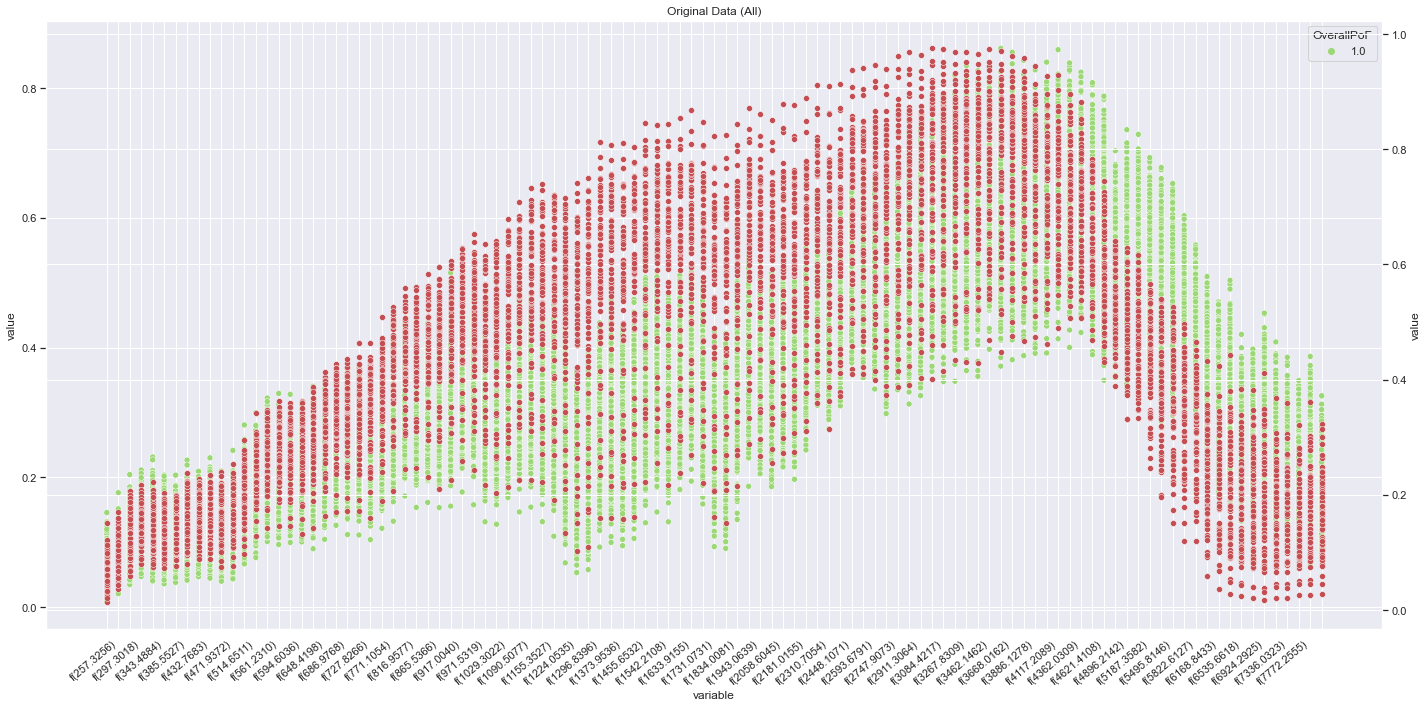

In [380]:
# Custom colours
# gen_viz_long = gen_viz_long.sort_values('support') # To ensure that support vector points are at the front

fig, ax = plt.subplots()

colors = ["#9CD876", "#D97C65", "#4856A8", "#4856A8"]# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# Plotting
# ax = sns.scatterplot(data = gen_viz_long, x='variable', y='value', hue=gen_viz_long[['support','OverallPoF']].apply(tuple, axis=1))
ax = sns.scatterplot(data = svm_viz_long[svm_viz_long['OverallPoF'] == 1],
                    x='variable', y='value',
                    hue='OverallPoF'
                    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title="Original Data (All)")

ax2 = ax.twinx()
sns.scatterplot(x='variable', y='value', data=svm_viz_long[svm_viz_long['support'] == 1], ax=ax2, color='r')

# Figure size and tick labels
sns.set(rc={'figure.figsize':(20,10)})
plt.setp(ax.get_xticklabels()[::2], visible=False)

# Layout
plt.tight_layout()
plt.show();

### Generated

In [345]:
grid_svm.fit(X_train_gen_scaled, y_train_gen)
svm_classifier = grid_svm.best_estimator_

GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'decision_function_shape': ['ovo', 'ovr'],
                         'kernel': ['linear', 'rbf'],
                         'shrinking': [True, False]})

In [346]:
# Predictions
y_test_pred_svm = svm_classifier.predict(X_test_scaled)
y_test_pred_svm_fails = svm_classifier.predict(X_test_fails_scaled)

In [347]:
accuracy_score(y_test, y_test_pred_svm)
accuracy_score(y_test_fails, y_test_pred_svm_fails)

0.8702928870292888

0.21052631578947367

#### Visualisation

In [348]:
support_vectors = svm_classifier.support_vectors_
support_vector_indices = svm_classifier.support_
print(support_vector_indices)

[ 257  897 1236 1557 1737 1852 1860 2429 2593 3411 3634 3675 3730 3837
 4133 4170 4299 4368 4466 4505 4572 4915 4975 5477 6105 6258 6259 6393
 6847 7006 7507 7891 7957 8249 8307 8351 9366 9409  223  376  467 1003
 1068 1246 1587 2079 2107 2571 3042 3196 3409 3590 3613 3906 4166 4354
 4482 4575 5089 5353 5533 5540 5757 6010 6067 6084 6100 6182 6309 7132
 7436 7610 8013 8706 9031 9168 9528 9588]


In [349]:
gen_viz = X_train_gen.copy(deep=True)
gen_viz['support'] = 0
gen_viz.loc[support_vector_indices,'support'] = 1
gen_viz = pd.concat([gen_viz, y_train_gen], axis=1)

cont_vars = [c for c in gen_viz if c[:2] != "f("]

gen_viz_long = gen_viz.melt(cont_vars)
gen_viz_long.head()

,AgeY,support,OverallPoF,variable,value
0,8.777562,0,0.0,f(226.0000),0.031031
1,8.784464,0,0.0,f(226.0000),0.027764
2,8.792300,0,0.0,f(226.0000),0.021731
3,8.944542,0,0.0,f(226.0000),0.091722
4,8.963581,0,1.0,f(226.0000),0.061470


/var/folders/23/sqlb91r144d65txwr_x9qnp80000gn/T/ipykernel_72557/3643938373.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


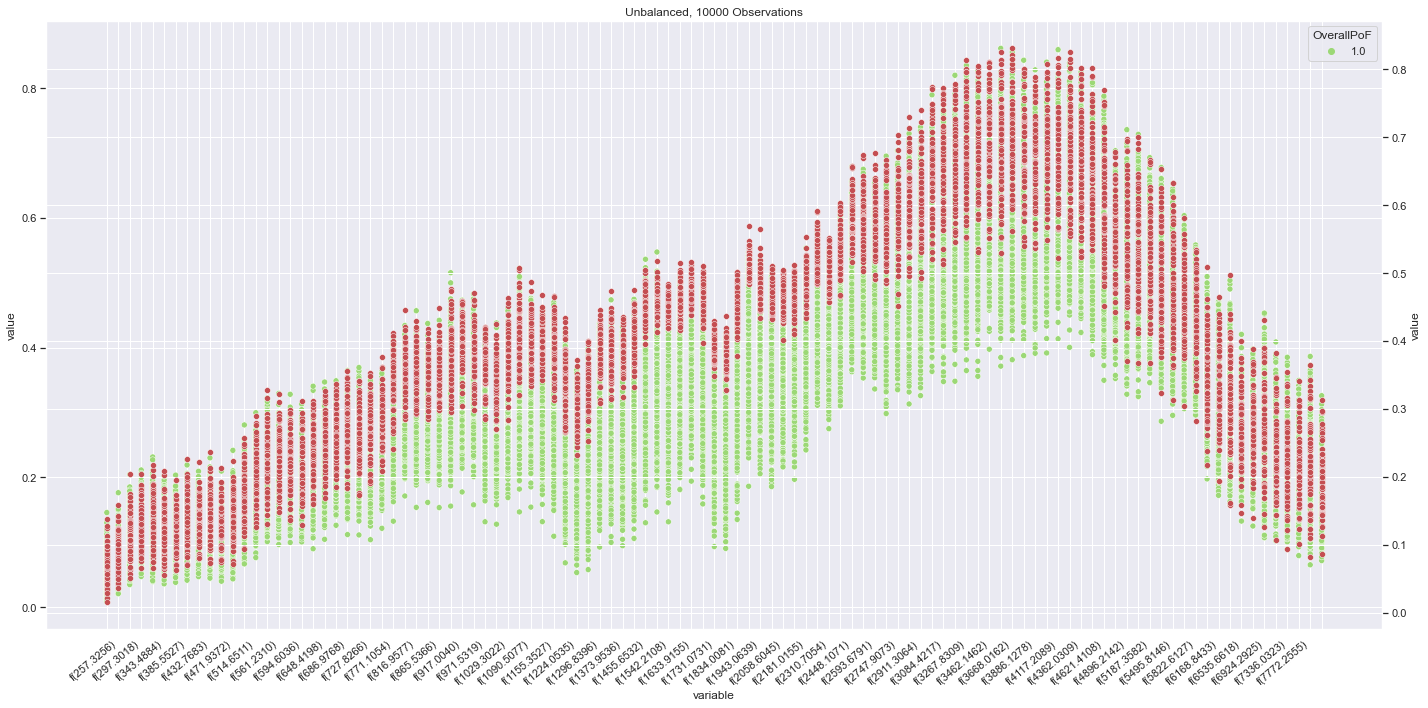

In [392]:
# Custom colours
# gen_viz_long = gen_viz_long.sort_values('support') # To ensure that support vector points are at the front

fig, ax = plt.subplots()

colors = ["#9CD876", "#D97C65", "#4856A8", "#4856A8"]# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# Plotting
# ax = sns.scatterplot(data = gen_viz_long, x='variable', y='value', hue=gen_viz_long[['support','OverallPoF']].apply(tuple, axis=1))
ax = sns.scatterplot(data = gen_viz_long[gen_viz_long['OverallPoF'] == 1],
                    x='variable', y='value',
                    hue='OverallPoF'
                    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title="Unbalanced, {} Observations".format(len(wba_gen)))

ax2 = ax.twinx()
sns.scatterplot(x='variable', y='value', data=gen_viz_long[gen_viz_long['support'] == 1], ax=ax2, color='r', ci=95)

# Figure size and tick labels
sns.set(rc={'figure.figsize':(20,10)})
plt.setp(ax.get_xticklabels()[::2], visible=False)

# Layout
plt.tight_layout()
plt.show();

### Generated (Balanced)

In [351]:
grid_svm.fit(X_train_bal_scaled, y_train_bal)
svm_classifier = grid_svm.best_estimator_

GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'decision_function_shape': ['ovo', 'ovr'],
                         'kernel': ['linear', 'rbf'],
                         'shrinking': [True, False]})

In [352]:
# Predictions
y_test_pred_svm = svm_classifier.predict(X_test_scaled)
y_test_pred_svm_fails = svm_classifier.predict(X_test_fails_scaled)

In [353]:
accuracy_score(y_test, y_test_pred_svm)
accuracy_score(y_test_fails, y_test_pred_svm_fails)

0.899581589958159

0.7368421052631579

In [354]:
X_train_bal.head()

,AgeY,f(226.0000),f(257.3256),f(280.6155),f(297.3018),f(324.2099),f(343.4884),f(363.9133),f(385.5527),f(408.4789),...,f(6168.8433),f(6349.6042),f(6535.6618),f(6727.1713),f(6924.2925),f(7127.1897),f(7336.0323),f(7550.9945),f(7772.2555),f(8000.0000)
0,0.0,0.050145,0.080743,0.113988,0.128884,0.122545,0.114438,0.116035,0.122428,0.133212,...,0.359383,0.321096,0.297198,0.283354,0.280423,0.249125,0.235874,0.211636,0.209451,0.197780
1,0.0,0.053382,0.086982,0.120038,0.134163,0.116584,0.115446,0.131846,0.132105,0.140447,...,0.322776,0.308312,0.265506,0.283525,0.261078,0.245840,0.215328,0.197682,0.215398,0.187515
2,0.0,0.047853,0.075256,0.094907,0.122745,0.105331,0.107080,0.094224,0.115008,0.125471,...,0.257074,0.224954,0.198009,0.205142,0.209967,0.208676,0.172444,0.157120,0.162567,0.157750
3,0.0,0.030619,0.052858,0.072496,0.085221,0.097726,0.081610,0.077290,0.096250,0.099965,...,0.351327,0.332626,0.298954,0.304271,0.256424,0.241067,0.201277,0.203927,0.189190,0.161743
4,0.0,0.053654,0.078757,0.103099,0.129536,0.125690,0.112773,0.109866,0.125684,0.126847,...,0.307686,0.291826,0.267522,0.256053,0.256987,0.241287,0.236782,0.198920,0.201728,0.174901


#### Visualisation

In [355]:
support_vectors = svm_classifier.support_vectors_
support_vector_indices = svm_classifier.support_
print(support_vector_indices)

[1425 1437 1532 1546 1603 1635 1655 1672 1683 1686 1759 1825 1853 1866
 1935 1974 1975 2039 2159 2251 2281 2526   49  134  153  165  166  362
  376  398  410  413  429  615  687  699  777  867  880  942 1000 1010
 1088 1161 1168 1186 1226 1274]


In [356]:
bal_viz = X_train_bal.copy(deep=True)
bal_viz['support'] = 0

bal_viz.loc[support_vector_indices,'support'] = 1
bal_viz = pd.concat([bal_viz, y_train_bal], axis=1)

cont_vars = [c for c in bal_viz if c[:2] != "f("]

bal_viz_long = bal_viz.melt(cont_vars)
bal_viz_long.head()

,AgeY,support,OverallPoF,variable,value
0,0.0,0,1.0,f(226.0000),0.050145
1,0.0,0,1.0,f(226.0000),0.053382
2,0.0,0,1.0,f(226.0000),0.047853
3,0.0,0,1.0,f(226.0000),0.030619
4,0.0,0,1.0,f(226.0000),0.053654


/var/folders/23/sqlb91r144d65txwr_x9qnp80000gn/T/ipykernel_72557/1057913160.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


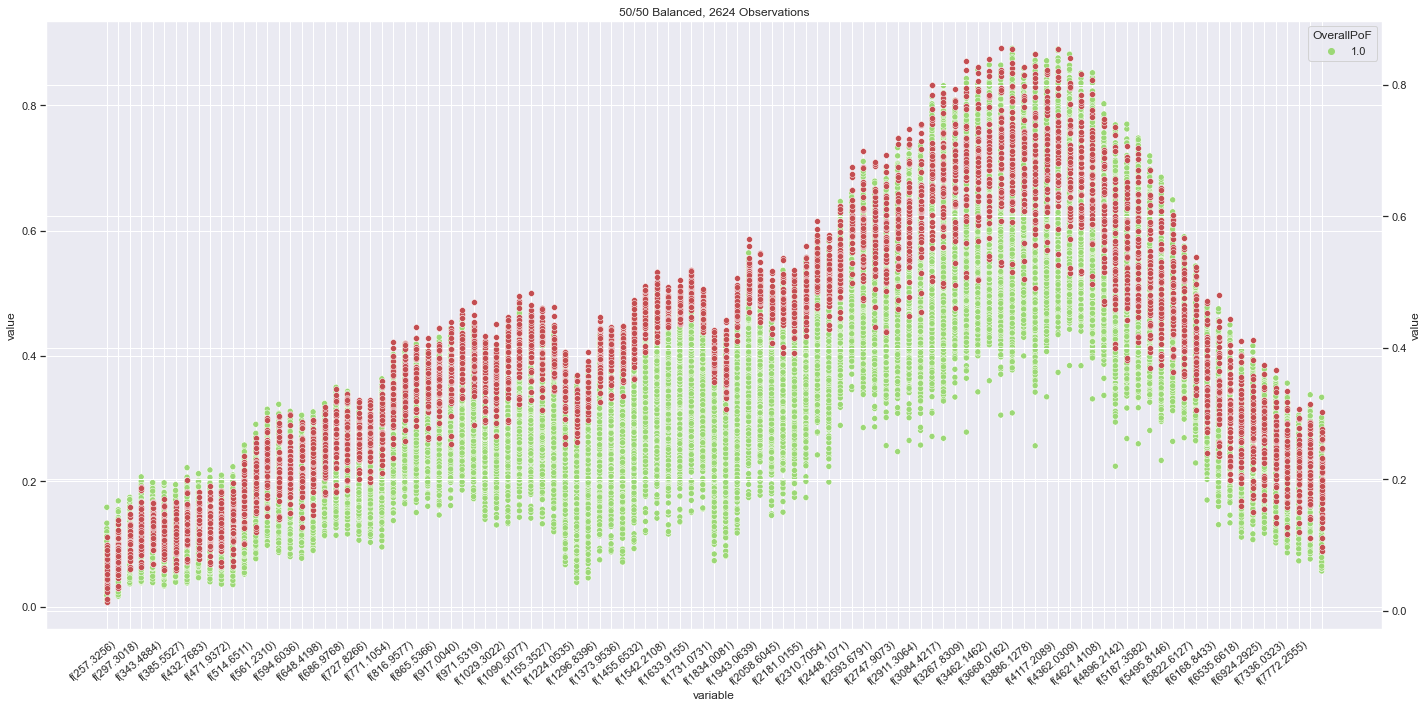

In [391]:
# Dual plotting
fig, ax = plt.subplots()

# Custom colours
colors = ["#9CD876", "#4856A8", "#D97C65", "#4856A8"]# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# Plotting
# ax = sns.scatterplot(data = bal_viz_long, x='variable', y='value', hue=bal_viz_long[['support','OverallPoF']].apply(tuple, axis=1))
ax = sns.scatterplot(data = bal_viz_long[bal_viz_long['OverallPoF'] == 1],
                    x='variable', y='value',
                    hue='OverallPoF')

# Tick labels and title
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title="50/50 Balanced, {} Observations".format(len(wba_gen_balanced)))

# Support vectors plot
ax2 = ax.twinx()
sns.scatterplot(x='variable', y='value', data=bal_viz_long[bal_viz_long['support'] == 1], ax=ax2, color='r', estimator=None)

sns.set(rc={'figure.figsize':(20,10)})

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

## Random Forest

In [358]:
from sklearn.ensemble import RandomForestClassifier

### GridSearch

In [359]:
param_grid = {'n_estimators': [100, 200, 300],
                'criterion': ['gini', 'entropy', 'log_loss']} 

rf_classifier = RandomForestClassifier(random_state = 42)

grid_rf = GridSearchCV(
  rf_classifier,
  param_grid, 
  cv = 3
  )

#### Generated

In [376]:
grid_rf.fit(X_train_gen, y_train_gen)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [100, 200, 300]})

In [377]:
rf_classifier = grid_rf.best_estimator_

In [378]:
rf_pred = rf_classifier.predict(X_test)
rf_pred_fails = rf_classifier.predict(X_test_fails)

In [379]:
accuracy_score(rf_pred, y_test)
accuracy_score(rf_pred_fails, y_test_fails)

0.9037656903765691

0.6842105263157895

#### Generated (Balanced)

In [372]:
grid_rf.fit(X_train_bal, y_train_bal)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [100, 200, 300]})

In [373]:
rf_classifier = grid_rf.best_estimator_

In [374]:
rf_pred = rf_classifier.predict(X_test)
rf_pred_fails = rf_classifier.predict(X_test_fails)

In [375]:
accuracy_score(rf_pred, y_test)
accuracy_score(rf_pred_fails, y_test_fails)

0.9079497907949791

0.7368421052631579

# TO DO: COMPARE WITH SMOTE